In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import matplotlib.pyplot as plt
import time
import copy
import os

from torch_lr_finder import LRFinder

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
data_dir = './dataset/'

In [4]:
data_transforms = {
    "train" : transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val" : transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test" : transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [5]:
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x:len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

In [6]:
batch_size = 100
learning_rate = 0.0057

In [7]:
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=batch_size, shuffle = True)
    for x in ["train", "validation"]
}

def imshow(inp, title = None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

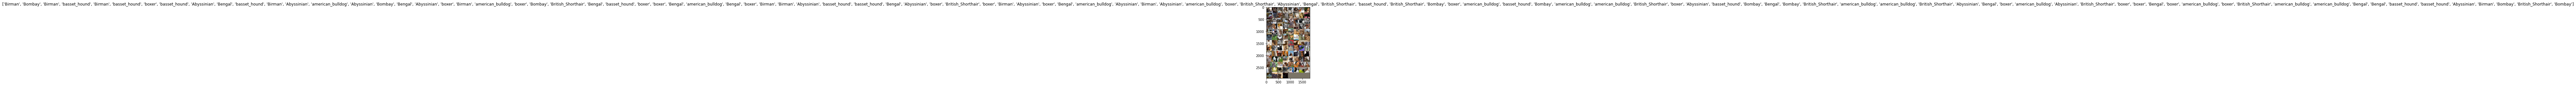

In [8]:
inputs, classes = next(iter(dataloaders["validation"]))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [9]:
bn_final = False
bn_types = (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)

In [10]:
net = models.resnet18(pretrained=True)
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz=None):
        "Output will be 2*sz or 2 if sz is None"
        super(AdaptiveConcatPool2d, self).__init__()
        self.output_size = sz or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

def head_blocks(in_dim, p, out_dim, activation=None):
    "Basic Linear block"
    layers = [
        nn.BatchNorm1d(in_dim),
        nn.Dropout(p),
        nn.Linear(in_dim, out_dim)
    ]
    
    if activation is not None:
        layers.append(activation)
        
    return layers       
    
def create_head(nf, nc, bn_final=False):
    "Model head that takes in 'nf' features and outputs 'nc' classes"
    pool = AdaptiveConcatPool2d()
    layers = [pool, nn.Flatten()]
    layers += head_blocks(nf, 0.5, nc,  nn.ReLU(inplace=True))
    
    if bn_final:
        layers.append(nn.BatchNorm1d(nc, momentum=0.01))
    
    return nn.Sequential(*layers)
    
def requires_grad(layer):
    "Determines whether 'layer' requires gradients"
    ps = list(layer.parameters())
    if not ps: return None
    return ps[0].requires_grad


def freeze_all(model_params):
    for param in model_params:
        param.requires_grad = False

In [12]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

body = nn.Sequential(*list(net.children())[:-2])
head = create_head(1024, 8, bn_final)

model = nn.Sequential(body, head)

# freeze the resnet34 base of the model
freeze_all(model[0].parameters())

# initialize the weights of the head
for child in model[1].children():
    if isinstance(child, nn.Module) and (not isinstance(child, bn_types)) and requires_grad(child): 
        nn.init.kaiming_normal_(child.weight)
        
model.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [13]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [14]:
# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(dataloaders["train"], end_lr=3, num_iter=100)
# lr_finder.plot()

In [15]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0057, pct_start=0.3, steps_per_epoch=len(dataloaders["train"]), epochs=15)

In [16]:
n_epochs = 15
print_every = 3
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(dataloaders["train"])
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(dataloaders["train"]):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (dataloaders["validation"]):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(dataloaders["validation"]))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    model.train()

Epoch 1

Epoch [1/15], Step [0/12], Loss: 3.0606

train-loss: 2.7090, train-acc: 15.9861
validation loss: 1.9831, validation acc: 31.7308

Improvement-Detected, save-model
Epoch 2

Epoch [2/15], Step [0/12], Loss: 2.2867

train-loss: 2.1438, train-acc: 46.3076
validation loss: 1.3157, validation acc: 74.0385

Improvement-Detected, save-model
Epoch 3

Epoch [3/15], Step [0/12], Loss: 0.7046

train-loss: 1.6119, train-acc: 81.7550
validation loss: 0.9379, validation acc: 89.4231

Improvement-Detected, save-model
Epoch 4

Epoch [4/15], Step [0/12], Loss: 0.2752

train-loss: 1.2669, train-acc: 92.3545
validation loss: 0.7712, validation acc: 93.7500

Epoch 5

Epoch [5/15], Step [0/12], Loss: 0.1099

train-loss: 1.0386, train-acc: 96.1772
validation loss: 0.6709, validation acc: 93.7500

Epoch 6

Epoch [6/15], Step [0/12], Loss: 0.1111

train-loss: 0.8895, train-acc: 95.2215
validation loss: 0.5794, validation acc: 94.7115

Improvement-Detected, save-model
Epoch 7

Epoch [7/15], Step [0/12]

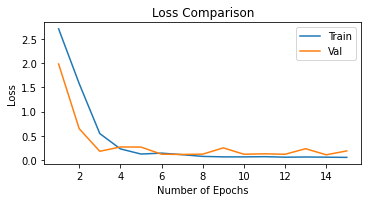

In [17]:
plt.figure(figsize=(5, 2.7), layout='constrained')
plt.plot([i for i in range(1, n_epochs+1)], train_loss, label='Train')
plt.plot([i for i in range(1, n_epochs+1)], val_loss, label='Val')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title("Loss Comparison")
plt.legend();

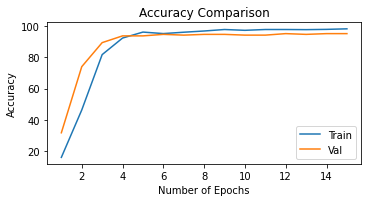

In [18]:
plt.figure(figsize=(5, 2.7), layout='constrained')
plt.plot([i for i in range(1, n_epochs+1)], train_acc, label='Train')
plt.plot([i for i in range(1, n_epochs+1)], val_acc, label='Val') 
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy Comparison")
plt.legend()

In [19]:
def visualize_model(model, num_images=10, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 1, 1, images_so_far)
                ax.axis("off")
                ax.set_title(f"Pred = {class_names[preds[j]]}, Actual = {class_names[labels[j]]}")
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

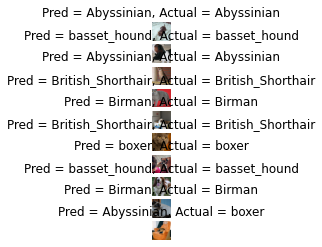

In [20]:
visualize_model(model, num_images=10)
plt.show()

In [21]:
summary(model, (3, 255,255))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [22]:
torch.save(model, "./model_classical(15).pt")